## Multi-fidelity Bayesian Optimization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
import torch

def test_function(input_dict):
    x = input_dict["x"]
    s = input_dict["s"]
    return {"f":np.sin(x) * np.exp((-s+1)/2)}


# define vocs
from xopt import VOCS
vocs = VOCS(
    variables={
        "x": [0, 2*math.pi],
    },
    objectives={"f": "MINIMIZE"},
)

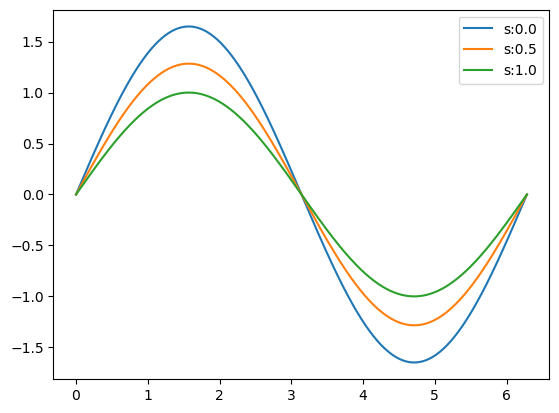

In [2]:
# plot the test function in input + fidelity space
test_x = np.linspace(*vocs.bounds, 1000)
fidelities = [0.0,0.5,1.0]

fig,ax = plt.subplots()
for ele in fidelities:
    f = test_function({"x":test_x, "s":ele})["f"]
    ax.plot(test_x, f,label=f"s:{ele}")

ax.legend()

In [4]:
# create xopt object
from xopt.generators import MultiFidelityBayesianGenerator
from xopt import Evaluator, Xopt

# get and modify default generator options
options = MultiFidelityBayesianGenerator.default_options()
options.acq.cost_function = lambda x: x[..., -1] + 0.1
generator = MultiFidelityBayesianGenerator(vocs, options=options)
evaluator = Evaluator(function=test_function)

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)
X.generator.options.dict()

{'optim': {'num_restarts': 20,
  'raw_samples': 20,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(x)>,
  'reference_point': None},
 'model': {'name': 'multi_fidelity',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

In [5]:
# evaluate initial points at mixed fidelities to seed optimization
X.evaluate_data(pd.DataFrame({"x":[math.pi / 4, math.pi / 2.],"s":[0.0, 0.5]}))

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.0,1.165822,0.000011,False
2,1.570796,0.5,1.284025,0.000002,False


In [6]:
# get the total cost of previous observations (base_cost + s for each measurement)
X.generator.calculate_total_cost()

tensor(0.7000, dtype=torch.float64)

In [7]:
X.generator.reference_point

tensor([-10.,   0.], dtype=torch.float64)

In [8]:
# run optimization until the cost budget is exhausted
budget = 10
while X.generator.calculate_total_cost() < budget:
    print(f"budget used: {X.generator.calculate_total_cost()}")
    X.step()

budget used: 0.7
budget used: 0.7999999999999999
budget used: 1.2819478699768578
budget used: 1.9867505388766133
budget used: 2.875165172433403
budget used: 3.975165172433403
budget used: 5.075165172433403
budget used: 6.1751651724334025
budget used: 7.275165172433403
budget used: 8.375165172433402
budget used: 9.036329086677204
budget used: 9.908296538082109


In [9]:
X.data

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.000000,1.165822e+00,0.000011,False
2,1.570796,0.500000,1.284025e+00,0.000002,False
3,6.283185,0.000000,-4.038202e-16,0.000010,False
4,0.000000,0.381948,0.000000e+00,0.000009,False
5,0.000000,0.604803,0.000000e+00,0.000018,False
6,0.000000,0.788415,0.000000e+00,0.000009,False
7,0.000000,1.000000,0.000000e+00,0.000010,False
8,1.553828,1.000000,9.998560e-01,0.000011,False
9,5.150824,1.000000,-9.054170e-01,0.000009,False
10,4.204262,1.000000,-8.736574e-01,0.000011,False


<Axes: xlabel='s'>

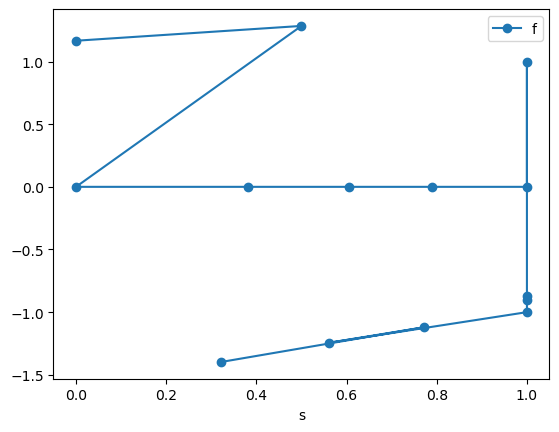

In [10]:
X.data.plot(x="s", y="f", style="o-")

In [ ]:
X.data